### Synopsis:
- load in normalized data for 10 patients and their masks
- shuffle data ie. by slices
- load model
- train slice by slice
- plot loss and dice coef
- plot predicted masks against ground truth masks

In [1]:
import utils.hgg_utils as hu
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm 
from model import unet
from utils.dice import dice_loss as dice
from utils.dice import dice_coef as dice_coef
from sklearn.utils import shuffle
from IPython import display

In [2]:
num_to_load = 10
n_slices = 155

### Load in some input data

In [3]:
patients = hu.get_each_normalized_hgg_folder()
some_data = np.ones([ num_to_load*155, 240, 240, 4])
some_data = hu.load_n_brains(some_data, 10, patients)
some_data = some_data.astype(np.float32)


### Load in corresponding masks

In [4]:
masks = hu.get_each_hgg_folder()
some_masks = np.ones([ num_to_load*155, 240, 240, 1])
some_masks = hu.load_n_masks(some_masks, 10, masks)
some_masks = some_masks.astype(np.float32)

### Shuffle data

In [5]:
some_data, some_masks = shuffle(some_data, some_masks, random_state=1)

### Model

In [6]:
seq_model = unet( input_size=(240,240,4), ds=1 )

In [7]:
my_opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [8]:
seq_model.compile(optimizer=my_opt, loss=dice, metrics=[dice_coef])

### Train

In [9]:
beg = 0
end = 1550

In [10]:
history = seq_model.fit(some_data[beg:end,...], some_masks[beg:end,...], epochs=5, batch_size=16)

Train on 1550 samples
Epoch 1/5
1550/1550 [==============================] - 63s 41ms/sample - loss: 0.9469 - dice_coef: 0.0531
Epoch 2/5
1550/1550 [==============================] - 50s 32ms/sample - loss: 0.9412 - dice_coef: 0.0588
Epoch 3/5
1550/1550 [==============================] - 50s 32ms/sample - loss: 0.9394 - dice_coef: 0.0606
Epoch 4/5
1550/1550 [==============================] - 50s 32ms/sample - loss: 0.9384 - dice_coef: 0.0616
Epoch 5/5
1550/1550 [==============================] - 50s 32ms/sample - loss: 0.9379 - dice_coef: 0.0621


### Train loss

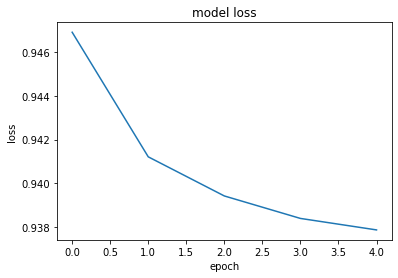

In [11]:
plt.plot( history.history["loss"])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

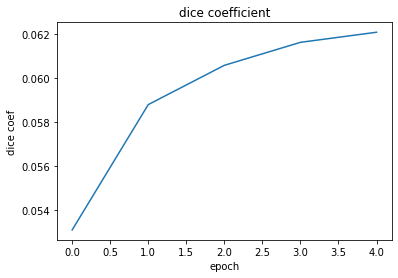

In [12]:
plt.plot( history.history["dice_coef"])
plt.title('dice coefficient')
plt.ylabel('dice coef')
plt.xlabel('epoch')
plt.show()

### Plot predictions against masks, just looking at first 10 out of 1550

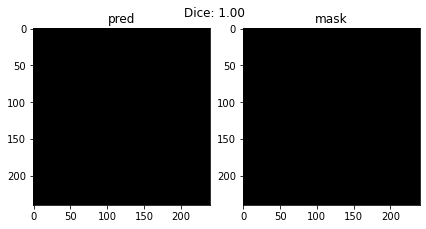

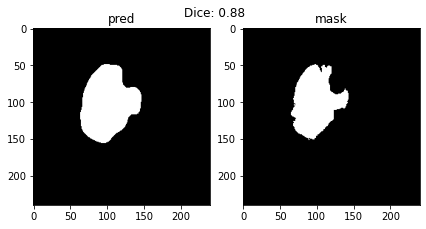

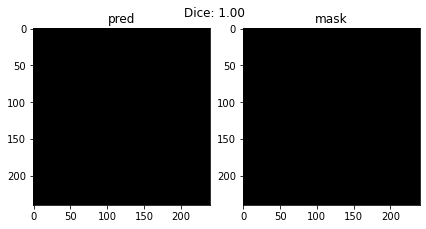

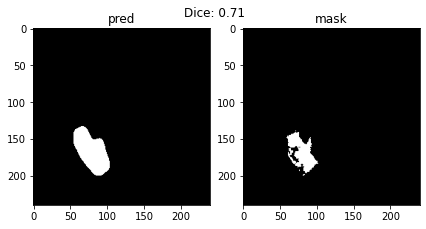

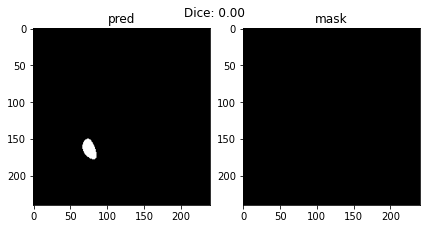

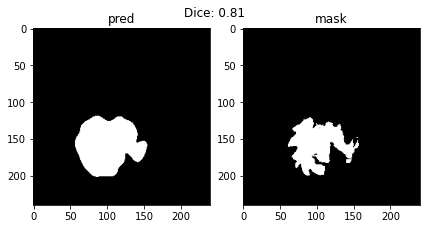

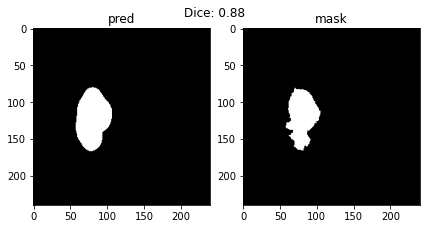

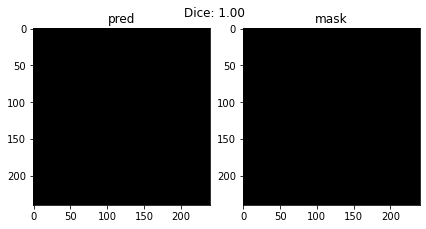

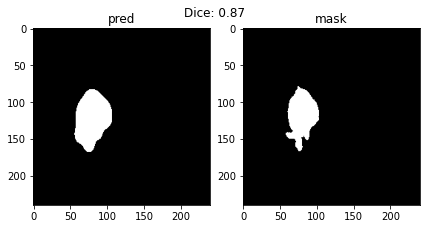

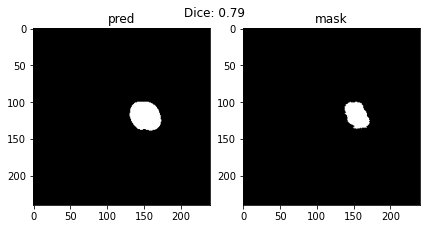

In [13]:
early_stop=10

for i in range(beg, early_stop):
    plt.figure(1, figsize=(6,6))

    p = seq_model.predict(some_data[i:i+1,:,:,:])

    #threshold the predicted mask
    p[np.where(p < 0.5)] = 0
    p[np.where(p >= 0.5)] = 1

    #Dice coef of thresholded predicted mask -- want it to be near 1.0
    metric = dice_coef(p, some_masks[i]).numpy()

    #plot predicted mask
    plt.subplot(221)
    plt.title("pred")
    plt.imshow(p[0,:,:,0].T, cmap="Greys_r", vmin=0, vmax=1)

    #plot ground truth mask
    plt.subplot(222)
    plt.title("mask")
    plt.imshow(some_masks[i,:,:,0].T, cmap="Greys_r", vmin=0, vmax=1)

    # Dice coef of thresholded mask -- want it to be near 1.0
    plt.suptitle("Dice: {:.2f}".format(metric))

    plt.tight_layout()
    plt.show()
    